# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the AZDIAS dataset.
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Check the structure of the feature summary.
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#Total number of records
azdias.shape[0]*azdias.shape[1]

75753785

In [6]:
# Number of missing values in the unprocessed dataset.
print(azdias.isnull().sum().sum())
# Proportion of missing values in the unprocessed dataset.
print(azdias.isnull().sum().sum()/(azdias.shape[0]*azdias.shape[1]))

4896838
0.0646414961312


In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert a string of a list into a list
def convert_string_to_list(x):
    new_list =[]
    x = x.split(',')
    for i in x:
        try:
            new_list.append(int(i))
        except: 
            new_list.append(i)
    return new_list  

In [8]:
# Remove the "[]" from the strings.
missing_unknown = feat_info['missing_or_unknown'].str.slice(1,-1)
# Apply convert function and append in a new column.
feat_info['missing_or_unknown_conv'] = missing_unknown.apply(convert_string_to_list)

In [9]:
#Check the structure of the updated feature summary.
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_conv
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [10]:
type(feat_info['missing_or_unknown_conv'][0])

list

In [11]:
# Convert missing or unknown values to NaNs in AZDIAS dataset.
for column in azdias.columns:
    azdias[column].replace(feat_info.set_index('attribute').loc[column, 'missing_or_unknown_conv'], np.NaN, inplace=True)   

In [12]:
# Check NaN values in converted AZDIAS dataset.
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# Number of NaN values after data processing.
print(azdias.isnull().sum().sum())
# Proportion of NaN values after data processing.
print(azdias.isnull().sum().sum()/(azdias.shape[0]*(azdias.shape[1])))

8373929
0.11054139407


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
NaNs_per_column = (azdias.isnull().sum(axis=0)/len(azdias))*100

In [15]:
NaNs_per_column.head(5)

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
dtype: float64

In [16]:
NaNs_per_column.sort_values()

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

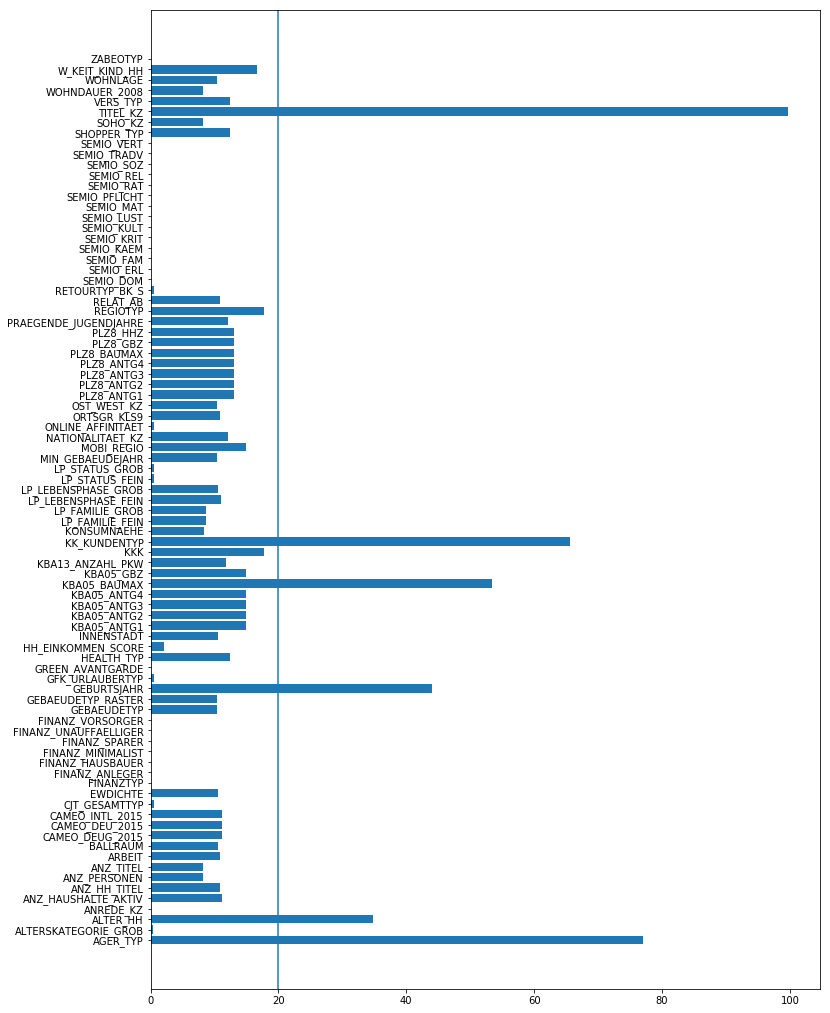

In [17]:
# Investigate patterns in the amount of missing data in each column.
NaNs_per_column = NaNs_per_column.reset_index()

plt.figure(figsize=(12,18))
bar_graph = plt.barh(NaNs_per_column['index'], NaNs_per_column[0])
plt.axvline(x=20)


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_wo_outliers = azdias.drop(['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX','KK_KUNDENTYP', 'TITEL_KZ'], axis=1)

In [19]:
# Check the structure after removing outlier columns.
print(azdias.shape)
print(azdias_wo_outliers.shape)

(891221, 85)
(891221, 79)


In [20]:
azdias_wo_outliers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [21]:
# Number of NaN values after removing outlier columns.
azdias_wo_outliers.isnull().sum().sum()

5035304

In [22]:
# Proportion of NaN values after removing outlier columns.
azdias_wo_outliers.isnull().sum().sum()/(azdias_wo_outliers.shape[0]*azdias_wo_outliers.shape[1])

0.071517643004883974

#### Discussion 1.1.2: Assess Missing Data in Each Column

In the unprocessed dataset, in total 4,896,838 NaN values (accouting for 6.8% of all records) were identfied. After converting unknown or missing data to NaN, 8,373,929 NaN values (accounting for 11.1% of all records) were found. 

Six out of 85 attributes in the dataset (ALTER_HH: 34.8%, GEBURTSJAHR: 44.0%, KBA05_BAUMAX: 53.5%, KK_KUNDENTYP:             65.6%, AGER_TYP: 77.0, TITEL_KZ: 99.8%) featured more than 20% NaN values and were completely removed from the dataset, resulting in a total of 5,035,304 NaN values, which account for 7.2% of all records in the processed dataframe. Moreover, 24 attributes having no NaN values were identified, some of which are used in the next chapter.

It is noticable that many attributes that fall in a category (indicated by a common prefix, e.g. PLZ8, FINANZ, SEMIO) feature the same number of NaN values, suggesting that these data were collected simultaneously.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
azdias_missing_data_per_row = azdias_wo_outliers.isnull().sum(axis=1)
azdias_missing_data_per_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

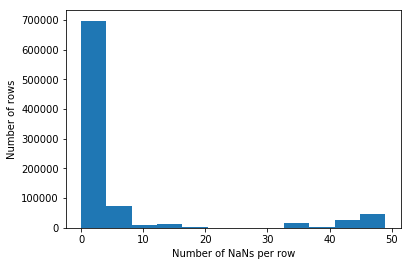

In [24]:
# Plot the number of NaN values per row in a histogram.
plt.hist(azdias_missing_data_per_row, bins=12)
plt.ylabel('Number of rows')
plt.xlabel('Number of NaNs per row')
plt.show()

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Less tham 25 NaN values:
azdias_lt_25NaNs = azdias_wo_outliers[azdias_wo_outliers.isnull().sum(axis=1) < 25]
# Greater than or equal to 25 NaN values
azdias_me_25NaNs = azdias_wo_outliers[azdias_wo_outliers.isnull().sum(axis=1) >= 25]

In [26]:
# Proportion of rows in both subsets.
# Less than 25 NaN values:
print(azdias_lt_25NaNs.shape[0]/(azdias_lt_25NaNs.shape[0] + azdias_me_25NaNs.shape[0]))
# More than 25 NaN values
print(azdias_me_25NaNs.shape[0]/(azdias_lt_25NaNs.shape[0] + azdias_me_25NaNs.shape[0]))

0.8952953307877619
0.10470466921223805


In [27]:
# Identify columns with no missing values
columns_wo_outliers = azdias_wo_outliers.columns[azdias_wo_outliers.notnull().all()]
print(columns_wo_outliers)
print(len(columns_wo_outliers))

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')
24


In [28]:
# defining function to compare value distribution between the two subsets
# in a list of specified columns

def value_distribution_comparison (columns):
    for column in columns:
        fig, ax =plt.subplots(1,2, figsize = (13,3))
        sns.countplot(azdias_lt_25NaNs[column], ax=ax[0])
        ax[0].set_title('No/Few NaNs')
        sns.countplot(azdias_me_25NaNs[column], ax=ax[1])
        ax[1].set_title('Many NaNs')
        
        fig.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


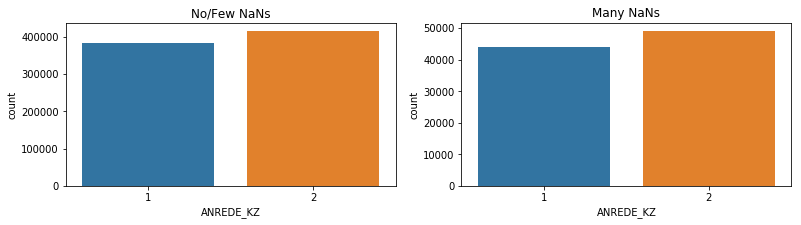

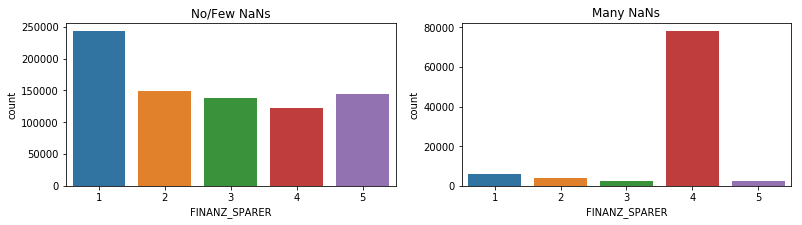

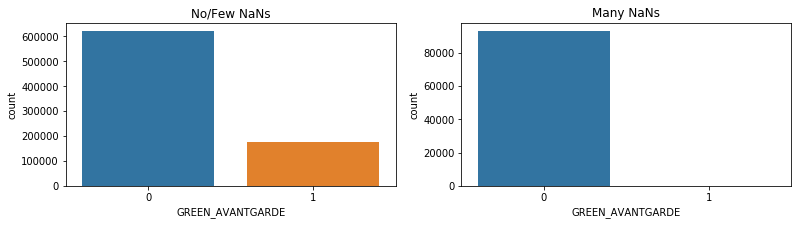

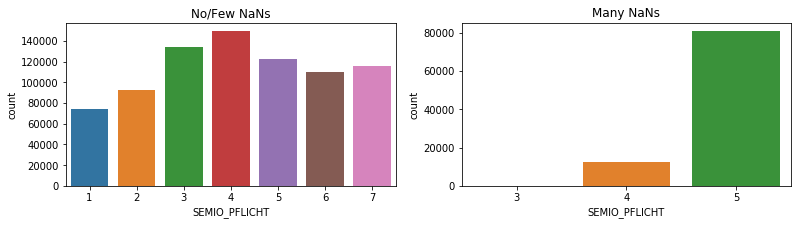

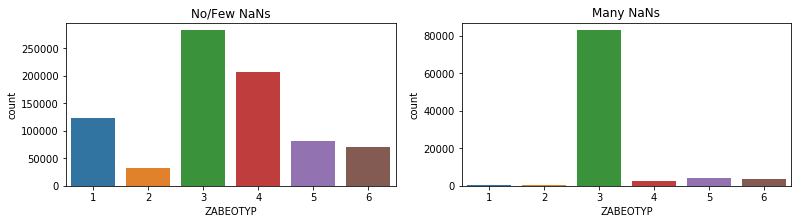

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_to_compare = ['ANREDE_KZ', 'FINANZ_SPARER', 'GREEN_AVANTGARDE', 'SEMIO_PFLICHT', 'ZABEOTYP']

value_distribution_comparison (columns_to_compare)


#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the distribution of NaN values in the histogram, the dataset can be divided into two subsets. The first, showing no/only a few (< 25) NaN values, accounts for 89.5% of all rows, the second, showing at least 25 NaN values, accounts for 10.5% of all rows.

The comparison of rows with no/few and many NaN values were conducted on five different columns that satisfy the following criteria: (1) no NaN values in the corresponding column; (2) investigated attributes fall into different categories. On that account, the following columns were assessed: ANREDE_KZ, FINANZ_SPARER, GREEN_AVANTGARDE, SEMIO_PFLICHT, ZABEOTYP. Except for the attribute "ANREDE_KZ" (relating to the gender), which is distributed equally among both subsets, the other selected columns show marked differences between the subset with no/low NaN values and many NaN values. 

Given the relatively low number of data in the second subset(at least 25 NaNs) and the observed qualitative differences, it is reasonable to exclude these rows from further analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# Remove outlier attributes from the feature summary.
feat_info_updated = feat_info[~feat_info['attribute'].isin(['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX','KK_KUNDENTYP', 'TITEL_KZ'])]
feat_info_updated.shape

(79, 5)

In [31]:
# How many features are there of each data type?
feat_info_updated['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Identify categorical features
categorical_feat = feat_info_updated[feat_info_updated['type'] == 'categorical']['attribute']
categorical_feat

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [33]:
#Turn Pandas Series into a Python list
categorical_feat_list = categorical_feat.tolist()
categorical_feat_list[:5]

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE']

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_categoricals_numeric = []
binary_categoricals_non_numeric = []
multi_level_categoricals = []

for feature in categorical_feat_list:
    if len(azdias_lt_25NaNs[feature].value_counts()) > 2:
        multi_level_categoricals.append(feature)
    elif (azdias_lt_25NaNs[feature].dtype != 'object'):
            binary_categoricals_numeric.append(feature)       
    else:
        binary_categoricals_non_numeric.append(feature)

In [35]:
# Check if the sum of all categorical variables in the three defined categories is equal to 18.
(len(binary_categoricals_numeric) + len(binary_categoricals_non_numeric) + len(multi_level_categoricals))

18

In [36]:
# List of binary categoricals.
binary_categoricals_numeric

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [37]:
binary_categoricals_non_numeric

['OST_WEST_KZ']

In [38]:
# Assess values of non-numeric categorical.
azdias_lt_25NaNs['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [39]:
# Re-encode non-numeric values as numbers.
azdias_lt_25NaNs['OST_WEST_KZ'] = azdias_lt_25NaNs['OST_WEST_KZ'].replace(['O', 'W'], [0, 1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
# Check values after re-encoding
azdias_lt_25NaNs['OST_WEST_KZ'].unique()

array([1, 0])

In [41]:
# List of multi-level categoricals.
multi_level_categoricals

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [42]:
# Drop 'GEBAEUDETYP' as it causes troubles during PCA transformation of customer data
azdias_lt_25NaNs = azdias_lt_25NaNs.drop('GEBAEUDETYP', axis=1)

In [43]:
multi_level_categoricals.remove('GEBAEUDETYP')

In [44]:
# Re-encode multi-level categoricals by one-hot encoding.
azdias_recoded = pd.get_dummies(azdias_lt_25NaNs, columns=multi_level_categoricals)

In [45]:
# Check structure of dataframe after one-hot encoding
print(azdias_lt_25NaNs.shape)
print(azdias_recoded.shape)

(797906, 78)
(797906, 187)


#### Discussion 1.2.1: Re-Encode Categorical Features

In the processed dataset, 18 categorical features were identified, of which 5 are binary categoricals (4 numeric and 1 non-numeric) and 13 are multi-level categoricals.

The following steps were performed:
1. The non-numeric values in the attribute "OST_WEST_KZ" were re-encoded as numbers.
2. Multi-level categoricals were re-encoded by using one-hot encoding.

All categorical features were kept for further analysis.

Retrospectively, the multi-level categorical feature "GEBAEUDETYP" was dropped from the dataset, as it generated different numbers of columns in the demographic and customer dataset after applying One-Hot Encoding.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE".
mixed_feat = feat_info_updated[feat_info_updated['type'] == 'mixed']['attribute']
mixed_feat

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [47]:
#Turn Pandas Series into a Python list.
mixed_feat_list = mixed_feat.tolist()
mixed_feat_list

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [48]:
# Assess unique values in "PRAEGENDE_JUGENDJAHRE".
azdias_recoded['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [49]:
azdias_recoded['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

Information about "PRAEGENDE_JUGENDJAHRE" extracted from the Data_Dictionary.md.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [50]:
# Engineer two new variables.
azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE']
azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE']

In [51]:
# Create dictionaries for the two new variables.
dict_movement = {1.:0,
                 2.:1,
                 3.:0,
                 4.:1,
                 5.:0,
                 6.:1,
                 7.:1,
                 8.:0,
                 9.:1,
                 10.:0,
                 11.:1,
                 12.:0,
                 13.:1,
                 14.:0,
                 15.:1
                }

dict_decade = {1.:0,
               2.:0,
               3.:1,
               4.:1,
               5.:2,
               6.:2,
               7.:2,
               8.:3,
               9.:3,
              10.:4,
              11.:4,
              12.:4,
              13.:4,
              14.:5,
              15.:5
              }

In [52]:
# Replace mixed_type features by numeric values by using the defined dictionaries.
azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(dict_movement)
azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(dict_decade)

In [53]:
# Check values and structure after recoding.
azdias_recoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique()

array([  0.,   1.,  nan])

In [54]:
azdias_recoded['PRAEGENDE_JUGENDJAHRE_DECADE'].unique()

array([  5.,   3.,   1.,   4.,   2.,  nan,   0.])

In [55]:
azdias_recoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,0.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,1.0,5.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,1,0,0,0,0,0,0,0.0,1.0


In [56]:
# Investigate "CAMEO_INTL_2015".
azdias_recoded['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

Information about "CAMEO_INTL_2015" extracted from the Data_Dictionary.md.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [57]:
#Engineer two new variables.
azdias_recoded['CAMEO_INTL_2015_WEALTH'] = azdias_recoded['CAMEO_INTL_2015']
azdias_recoded['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_recoded['CAMEO_INTL_2015']

In [58]:
# Create dictionaries for the two new variables.
dict_wealth = {'11':0,
               '12':0,
               '13':0,
               '14':0,
               '15':0,
               '21':1,
               '22':1,
               '23':1,
               '24':1,
               '25':1,
               '31':2,
               '32':2,
               '33':2,
               '34':2,
               '35':2,
               '41':3,
               '42':3,
               '43':3,
               '44':3,
               '45':3,
               '51':4,
               '52':4,
               '53':4,
               '54':4,
               '55':4
               }

dict_life_stage = {'11':0,
                   '12':1,
                   '13':2,
                   '14':3,
                   '15':4,
                   '21':0,
                   '22':1,
                   '23':2,
                   '24':3,
                   '25':4,
                   '31':0,
                   '32':1,
                   '33':2,
                   '34':3,
                   '35':4,
                   '41':0,
                   '42':1,
                   '43':2,
                   '44':3,
                   '45':4,
                   '51':0,
                   '52':1,
                   '53':2,
                   '54':3,
                   '55':4
                   }

In [59]:
# Replace mixed_type features by numeric values by using the defined dictionaries.
azdias_recoded['CAMEO_INTL_2015_WEALTH'] = azdias_recoded['CAMEO_INTL_2015_WEALTH'].replace(dict_wealth)
azdias_recoded['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_recoded['CAMEO_INTL_2015_LIFE_STAGE'].replace(dict_life_stage)

In [60]:
# Check values and structure after recoding.
azdias_recoded['CAMEO_INTL_2015_WEALTH'].unique()

array([  4.,   1.,   0.,   3.,   2.,  nan])

In [61]:
azdias_recoded['CAMEO_INTL_2015_LIFE_STAGE'].unique()

array([  0.,   3.,   1.,   2.,   4.,  nan])

In [62]:
azdias_recoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,5.0,4.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,5.0,1.0,3.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,3.0,0.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,3.0,3.0,2.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,1.0,4.0,3.0


In [63]:
# Remove all mixed_type columns from the dataframe.
azdias_final_recoded = azdias_recoded.drop(mixed_feat_list, axis=1)

In [64]:
# Check structure of the recoded dataframe.
azdias_final_recoded.head() 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,5.0,4.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,5.0,1.0,3.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,3.0,0.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,3.0,3.0,2.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,1.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Six mixed-type features were identified in the dataset: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015, PLZ8_BAUMAX

For two mixed-type attributes (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015), new features were created as follows:

1. PRAEGENDE_JUGENDJAHRE
The original feature, which relates to the dominating movement during the person's youth, were split into the corresponding decade (ordinal data) and the type of movement (mainstream vs. avantgarde) (binary data).

2. CAMEO_INTL_2015
The original feature, which relates to the wealth/life stage topoloy according to international code, were split into the wealth of the household (ordinal data) and the life-stage (ordinal data).

This was achieved by creating dictionaries for the above-mentioned categories and replacing the existing values in two newly engineered variables. 

As the created variables are ordinal or binary categoricals no further re-encoding is necessary.

The original features of these two reengieered as well as the four other mixed-type features were removed.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# No further actions required.

In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# No further actions required.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert missing or unknwon values in the feature summary.
    feat_info_new = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    missing_unknown = feat_info_new['missing_or_unknown'].str.slice(1,-1)
    feat_info_new['missing_or_unknown_conv'] = missing_unknown.apply(convert_string_to_list)
    
    # Identify missing or unknown values in the dataframe and convert them to NaNs.
    for column in df.columns:
        df[column].replace(feat_info_new.set_index('attribute').loc[column, 'missing_or_unknown_conv'], np.NaN, inplace=True) 
    
    # Remove the selected outliers from the dataframe.
    df = df.drop(['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX','KK_KUNDENTYP', 'TITEL_KZ'], axis=1)
    
    # Remove rows with greater than or equal to 25 NaN values.
    df = df[df.isnull().sum(axis=1) < 25]
    
    # Assess numeric/non-numeric categorical and multi-level categorical variables.
    binary_categoricals_numeric = []
    binary_categoricals_non_numeric = []
    multi_level_categoricals = []

    for feature in categorical_feat_list:
        if len(df[feature].value_counts()) > 2:
            multi_level_categoricals.append(feature)
        elif (df[feature].dtype != 'object'):
            binary_categoricals_numeric.append(feature)       
        else:
            binary_categoricals_non_numeric.append(feature)
            
    # Re-encode non-numeric values as numbers.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['O', 'W'], [0, 1])
    
    # Drop 'GEBAEUDETYP' as it causes troubles during PCA transformation of customer data
    df = df.drop('GEBAEUDETYP', axis=1)
    multi_level_categoricals.remove('GEBAEUDETYP')
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=multi_level_categoricals)
    
    # Re-encode Mixed-Type Features
    
    # 1. PRAEGENDE_JUGENDJAHRE
    # Engineer two new variables
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    # Create dictionaries for the two new variables.
    dict_movement = {1.:0,2.:1,3.:0,4.:1,5.:0,6.:1,7.:1,8.:0,9.:1,10.:0,11.:1,12.:0,13.:1,14.:0,15.:1}
    dict_decade = {1.:0,2.:0,3.:1,4.:1,5.:2,6.:2,7.:2,8.:3,9.:3,10.:4,11.:4,12.:4,13.:4,14.:5,15.:5}
    # Replace mixed_type features by numeric values by using the defined dictionaries.
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(dict_movement)
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(dict_decade)
    
    # 2. CAMEO_INTL_2015 
    #Engineer two new variables.
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015']
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015']
    # Create dictionaries for the two new variables.
    dict_wealth = {'11':0,'12':0,'13':0,'14':0,'15':0,'21':1,'22':1,'23':1,'24':1,'25':1,'31':2,'32':2,
                   '33':2,'34':2,'35':2,'41':3,'42':3,'43':3,'44':3,'45':3,'51':4,'52':4,'53':4,'54':4,
                   '55':4}
    dict_life_stage = {'11':0,'12':1,'13':2,'14':3,'15':4,'21':0,'22':1,'23':2,'24':3,'25':4,'31':0,
                       '32':1,'33':2,'34':3,'35':4,'41':0,'42':1,'43':2,'44':3,'45':4,'51':0,'52':1,
                       '53':2,'54':3,'55':4}
    # Replace mixed_type features by numeric values by using the defined dictionaries.
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015_WEALTH'].replace(dict_wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015_LIFE_STAGE'].replace(dict_life_stage) 
    
    # # Remove all mixed_type columns from the dataframe.
    mixed_feat_list = mixed_feat.tolist()
    df = df.drop(mixed_feat_list, axis=1)
    
    # Return the cleaned dataframe.
    return df

In [68]:
# Apply clean_data funtion on unprocessed Azdias dataset.
azdias_test = clean_data(azdias)

In [69]:
# Show that the dataframe obtained after applying the defined function is equal to the manually processed dataframe.
azdias_final_recoded.equals(azdias_test)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# Number of NaN values after removing outlier columns.
azdias_final_recoded.isnull().sum().sum()

760310

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
replace_NaNs = Imputer(missing_values='NaN', strategy='most_frequent')
azdias_imputed = pd.DataFrame(replace_NaNs.fit_transform(azdias_final_recoded))

In [72]:
# Check the number of NaN values after applying an imputer
azdias_imputed.isnull().sum().sum()

0

In [73]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)

In [74]:
# Create a dataframe and rename columns
azdias_scaled = pd.DataFrame(azdias_scaled)
azdias_scaled.columns = list(azdias_final_recoded.columns)

# Check the structure of the dataframe
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.766583,0.957932,-1.494563,1.537958,-1.040677,1.466028,0.958855,1.339191,-0.530442,1.010173,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.530442,1.098148,1.175762,-1.249066
1,0.200534,0.957932,-1.494563,0.864598,-1.766947,-0.570971,0.244297,1.339191,1.885219,1.010173,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,1.885219,1.098148,-0.869616,0.766959
2,1.184092,0.957932,0.683201,-0.482123,1.138132,-0.570971,-1.184817,-0.791446,-0.530442,-0.311822,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.530442,-0.267680,-1.551409,-0.577058
3,0.200534,-1.043916,0.683201,0.191237,0.411863,-1.249970,0.244297,-0.791446,-0.530442,1.010173,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.530442,-0.267680,0.493969,0.094950
4,-1.766583,0.957932,-0.042721,-1.155483,1.138132,-0.570971,-0.470260,1.339191,-0.530442,1.010173,...,-0.150079,-0.162558,-0.189558,-0.1798,-0.192787,-0.089765,-0.530442,-1.633507,1.175762,0.766959


### Discussion 2.1: Apply Feature Scaling

All NaN values were replaced with the most frequent value in the corresponding column using an Imputer. For scaling, StandardScaler was applied to the dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_scaled)

In [76]:
# Investigate the variance accounted for by each principal component and the cumulative variance
# Function provided in the course.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

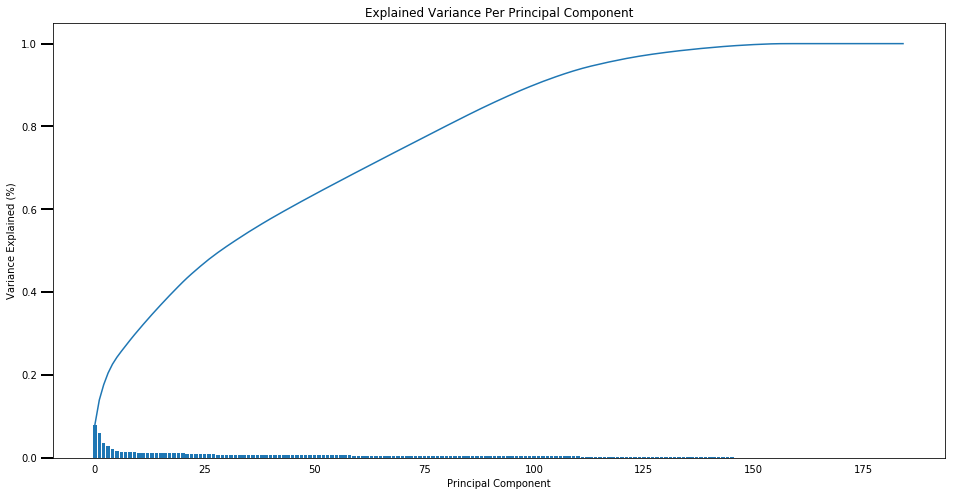

In [77]:
# Apply function and plot the data
scree_plot(azdias_pca)

In [78]:
# Explained variance by the first five principal components.
pca.explained_variance_ratio_[0:5]

array([ 0.08010608,  0.05948138,  0.03689595,  0.02819264,  0.02137071])

In [79]:
# Compute how man principal components are required to achieve > 85% variance.
explained_variance = 0
for component in range(0,196):
    explained_variance += pca.explained_variance_ratio_[component]
    if explained_variance > 0.85:
        break        
component   

90

In [80]:
# Cumulative sum of the first 91 principal components.
pca.explained_variance_ratio_[:91].cumsum()

array([ 0.08010608,  0.13958747,  0.17648342,  0.20467606,  0.22604677,
        0.24263011,  0.25689499,  0.27063092,  0.2839898 ,  0.29707506,
        0.30967435,  0.32203894,  0.33414296,  0.34614408,  0.35781465,
        0.36936215,  0.38069267,  0.39192159,  0.40289494,  0.41365456,
        0.42426732,  0.43442013,  0.44401368,  0.45323509,  0.46234633,
        0.47105447,  0.47973906,  0.48771755,  0.49565407,  0.50321927,
        0.51052201,  0.51772863,  0.52469847,  0.5316271 ,  0.5384664 ,
        0.54526942,  0.55183632,  0.55832324,  0.56474222,  0.57112631,
        0.57727577,  0.58335567,  0.58937676,  0.59535649,  0.60128501,
        0.60718867,  0.61303629,  0.61882404,  0.62458837,  0.6303346 ,
        0.63605937,  0.64174036,  0.6473995 ,  0.65302473,  0.65864115,
        0.66424641,  0.66982907,  0.67540264,  0.68095965,  0.68651261,
        0.69204847,  0.69758303,  0.70310015,  0.70860768,  0.71411234,
        0.71960842,  0.72509605,  0.73057319,  0.73604671,  0.74

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_91 = PCA(n_components=91)
azdias_pca_91 = pca_91.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

SKLearn's PCA class was used to apply principal component analysis on the data using default parameters. A scree plot was used to visualize the variance explained by each principal component as well as the cumulative variance.

As the primary goal of the PCA was to reduce the dimensionality of the data for a classification algorithm, a cumulative explained variance of 85% was deemed sufficient. To achieve this, it was computed that 91 principal components are required.

Consequently, PCA was re-applied by setting n_components = 91.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights_pca (df, pca, no_component, no_features):
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[no_component - 1]
    top_weights = components.abs().sort_values(ascending=False).head(no_features).index
    components = components.filter(top_weights)
    
    components.plot(kind='bar',
                 title='Most {} weighted features for PCA component {}'.format(no_features, no_component),
                 figsize=(12, 6));
    plt.axhline(y=0, linewidth = 1, color = 'k')
    plt.show()
    
    return components

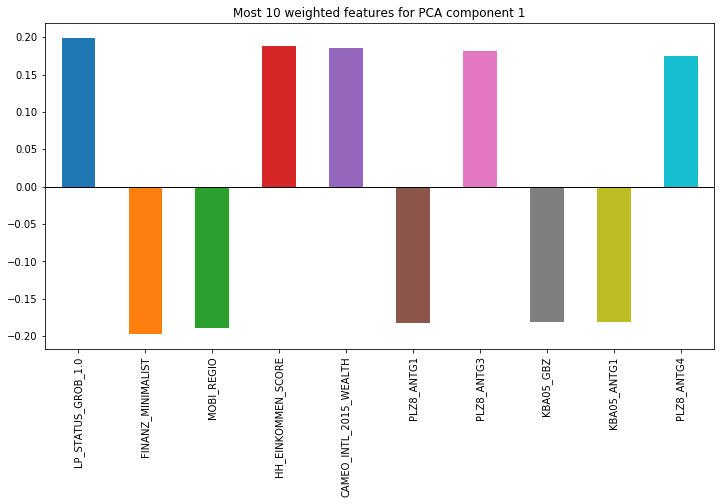

LP_STATUS_GROB_1.0        0.1992
FINANZ_MINIMALIST        -0.1977
MOBI_REGIO               -0.1887
HH_EINKOMMEN_SCORE        0.1878
CAMEO_INTL_2015_WEALTH    0.1862
PLZ8_ANTG1               -0.1830
PLZ8_ANTG3                0.1821
KBA05_GBZ                -0.1817
KBA05_ANTG1              -0.1815
PLZ8_ANTG4                0.1750
Name: 0, dtype: float64


In [83]:
first_pc = weights_pca(azdias_scaled, pca, 1, 10)
print(first_pc)

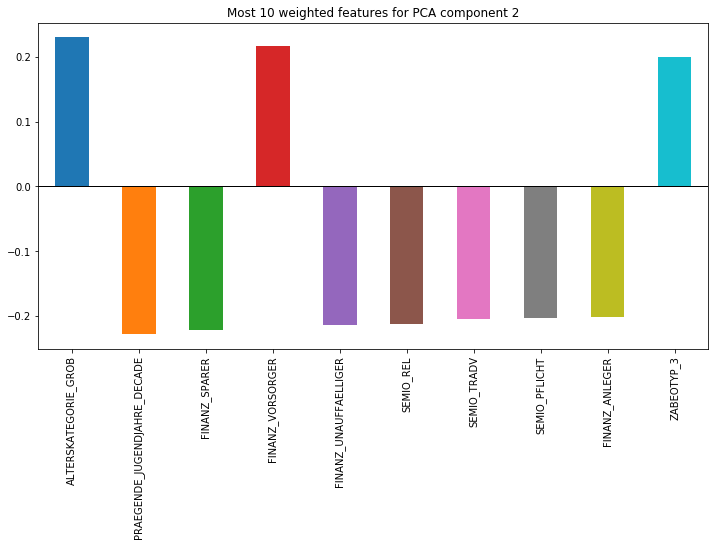

ALTERSKATEGORIE_GROB            0.2300
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2280
FINANZ_SPARER                  -0.2228
FINANZ_VORSORGER                0.2162
FINANZ_UNAUFFAELLIGER          -0.2141
SEMIO_REL                      -0.2127
SEMIO_TRADV                    -0.2058
SEMIO_PFLICHT                  -0.2028
FINANZ_ANLEGER                 -0.2017
ZABEOTYP_3                      0.2003
Name: 1, dtype: float64


In [84]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_pc = weights_pca(azdias_scaled, pca, 2, 10)
print(second_pc)

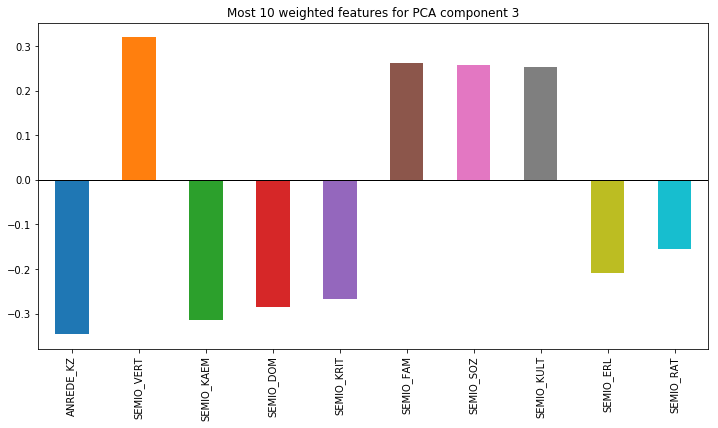

ANREDE_KZ    -0.3454
SEMIO_VERT    0.3191
SEMIO_KAEM   -0.3151
SEMIO_DOM    -0.2845
SEMIO_KRIT   -0.2674
SEMIO_FAM     0.2612
SEMIO_SOZ     0.2576
SEMIO_KULT    0.2524
SEMIO_ERL    -0.2084
SEMIO_RAT    -0.1548
Name: 2, dtype: float64


In [85]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc = weights_pca(azdias_scaled, pca, 3, 10)
print(third_pc)

### Discussion 2.3: Interpret Principal Components

The ten most weighted features (positively related (+)/negatively related (-)) for the first principal component are:
1. LP_STATUS_GROB_10 (+, social status)
2. FINANZ_MINIMALIST (-, low financial interest)
3. MOBI_REGIO (-, movement patterns)
4. HH_EINKOMMEN_SCORE (+, estimated household net income)
5. CAMEO_INTL_2015_WEALTH (+, wealth level of household)
6. PLZ8_ANTG1 (-, number of 1-2 family houses in plz region)
7. PLZ8_ANTG3 (+, number of 6-8 family houses in plz region)
8. KBA05_GBZ (-, number of buildings in the microcell)
9. KBA05_ANTG1 (-, number of 1-2 family houses in the microcell)
10. PLZ8_ANTG4 (+, number of 16+ family houses in plz region)

The majority of features asociated with the first PC relates to the person's wealth (positive correlation) and the residential area(positive correlation with large buildings as they can be mainly found in urban areas, negative correlation with smaller houses as typical for rural areas.)


The ten most weighted features (positively related (+)/negatively related (-)) for the second principal component are:
1. ALTERSKATEGORIE_GROB (+, estimated age on given name analysis)
2. PRÄGENDE_JUGENDJAHRE_DECADE (-, decade of person's youth)
3. FINANZ_SPARER (-, money saver)
4. FINANZ_VORSORGER (+, financially prepared)
5. FINANZ_UNAUFFÄLLIGER (-, financially inconspicuous)
6. SEMIO_REL  (-, religious)
7. SEMIO_TRADV(-, traditional minded)
8. SEMIO_PFLICHT (-, dutiful)
9. FINANZ_ANLEGER (-, investor)
10. ZABEOTYP (+, Energy consumption)

The second PC is mainly innfluecend by the age (positive correlation), investment behavior (indicative of moderate investors) and personality traits (indicative of conservative characters)


The ten most weighted features (positively related (+)/negatively related (-)) for the third principal component are:
1. ANREDE_KZ (-, Gender)
2. SEMIO_VERT (+, dreamful)
3. SEMIO_KAEM (-, combative attitude)
4. SEMIO_DOM (-, dominant minded)
5. SEMIO_KRIT (-, critical-minded)
6. SEMIO_FAM (+, family-minded)
7. SEMIO_SOZ (+, socially minded
8. SEMIO_KULT (+, cultural-minded)
9. SEMIO_(ERL (-, event-oriented)
10. SEMIO_RAT (-, rational)

The features associated with the third PC relates to the person's gender (predominantly males) and her/his personality traits as well as behavioral patterns.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [86]:
# Create an auxiliary dataset with 10% of data.
azdias_sample = azdias_pca_91[np.random.choice(len(azdias_pca_91), int(len(azdias_pca_91)*0.10))]
azdias_sample 

array([[ 3.38696912,  1.82872526,  2.24075751, ..., -0.10675326,
         1.52622522, -1.46875138],
       [-4.45235881,  1.96911034, -2.17347628, ...,  0.55138636,
         1.01774142,  0.82137301],
       [-1.21083019, -4.87034462,  5.03066704, ...,  0.81097368,
         1.88488017, -0.62621889],
       ..., 
       [-2.64705647, -4.45726323,  1.15532723, ..., -0.34098519,
         0.3345398 , -1.49306528],
       [-4.72996764,  0.13930539, -3.6941284 , ..., -0.01996034,
        -0.79656805, -0.0394994 ],
       [ 1.2004202 ,  4.47119046, -0.29392905, ..., -0.4997986 ,
         1.31627288, -1.45207945]])

In [87]:
# Over a number of different cluster counts...
sse = []
k_range = np.arange(3, 30)
for k in k_range:
    # run k-means clustering on the data
    kmeans = KMeans(k)
    kmeans.fit(azdias_sample)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(azdias_sample))
    sse.append(score)
    print('Clustering done for {} ks, with SSE {}'.format(k, score))

Clustering done for 3 ks, with SSE 11199239.037813768
Clustering done for 4 ks, with SSE 10902245.690845337
Clustering done for 5 ks, with SSE 10664814.15864779
Clustering done for 6 ks, with SSE 10512654.344482642
Clustering done for 7 ks, with SSE 10391379.45087768
Clustering done for 8 ks, with SSE 10271491.470395714
Clustering done for 9 ks, with SSE 10177085.543133553
Clustering done for 10 ks, with SSE 10083114.50552198
Clustering done for 11 ks, with SSE 9971620.071397407
Clustering done for 12 ks, with SSE 9914104.328882987
Clustering done for 13 ks, with SSE 9846939.376472838
Clustering done for 14 ks, with SSE 9764758.090061715
Clustering done for 15 ks, with SSE 9729559.561788285
Clustering done for 16 ks, with SSE 9652431.017777381
Clustering done for 17 ks, with SSE 9597730.714064928
Clustering done for 18 ks, with SSE 9555977.275065072
Clustering done for 19 ks, with SSE 9482830.452199092
Clustering done for 20 ks, with SSE 9328740.140478462
Clustering done for 21 ks, wit

Text(0,0.5,'SSE')

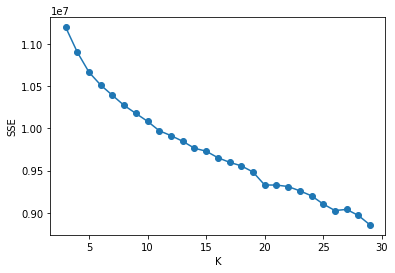

In [88]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_range, sse, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_n15 = KMeans(n_clusters = 15)
model_final = kmeans_n15.fit(azdias_pca_91)
demo_pred = model_final.predict(azdias_pca_91)

### Discussion 3.1: Apply Clustering to General Population

To determine the optimal number of clusters, a small toy dataset was created by randomly selecting 10% of the rows from the original dataset, leading to a reduction of the computation time and smaller sum of squared errors (SSE) values. Following this, the SSE was computed by using sklearn's score() method and plotted as a function of the number of selected clusters.

Although no clearly distinguishable point of inflection can be derived using the Elbow Method, the number of clusters was set to 15 for the final model, as the curve starts to flatten around this number.




### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [90]:
# Load in the general demographics data for customers.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [91]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_final_recoded = clean_data(customers)

In [92]:
#replace_NaNs = Imputer(missing_values='NaN', strategy='most_frequent')

In [93]:
customers_imputed = pd.DataFrame(replace_NaNs.transform(customers_final_recoded))

In [94]:
customers_scaled = scaler.transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.columns = list(customers_final_recoded.columns)

In [95]:
customers_pca = pca_91.transform(customers_scaled)

In [96]:
customers_pred = model_final.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [97]:
# Count the number of persons in each cluster (demographic dataset):
unique_demo, counts_demo = np.unique(demo_pred, return_counts=True)
dict(zip(unique_demo, counts_demo))

{0: 3340,
 1: 62560,
 2: 99451,
 3: 55135,
 4: 7145,
 5: 62849,
 6: 48293,
 7: 80573,
 8: 61722,
 9: 90335,
 10: 31013,
 11: 66955,
 12: 76576,
 13: 46651,
 14: 5308}

In [98]:
# Proportion of persons in each cluster
dict_demo = dict(zip(unique_demo, (counts_demo/(len(demo_pred)))))

In [99]:
# Count the number of persons in each cluster (customers dataset):
unique_customers, counts_customers = np.unique(customers_pred, return_counts=True)
dict(zip(unique_customers, counts_customers))

{0: 2828,
 1: 7672,
 2: 1413,
 3: 4357,
 4: 1763,
 5: 42654,
 6: 10560,
 7: 14944,
 8: 1496,
 9: 26617,
 10: 11747,
 11: 1030,
 12: 11518,
 13: 2311,
 14: 791}

In [100]:
# Proportion of persons in each cluster
dict_customers = dict(zip(unique_customers, (counts_customers/(len(customers_pred)))))

Text(0,0.5,'Relative quantity in dataset')

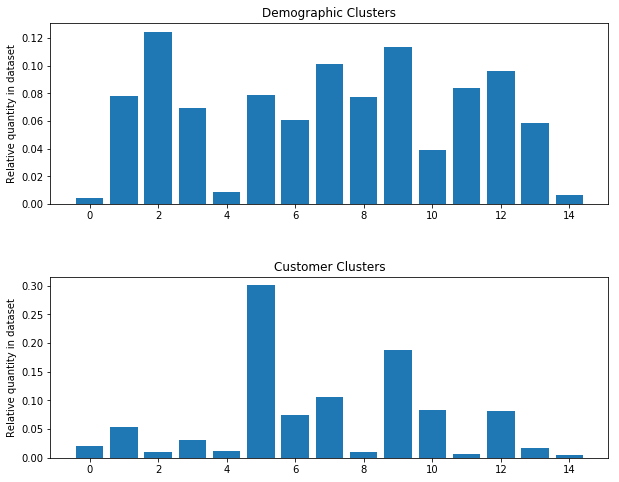

In [114]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (10,8))
figure.subplots_adjust(hspace = 0.4)

ax1.bar(range(len(dict_demo)), list(dict_demo.values()), align='center')
ax1.set_title('Demographic Clusters')
ax1.set_ylabel("Relative quantity in dataset")

ax2.bar(range(len(dict_customers)), list(dict_customers.values()), align='center')
ax2.set_title('Customer Clusters')
ax2.set_ylabel("Relative quantity in dataset")

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Find the maximum ratio between proportion in customer cluster and demographic cluster
# Use a dict comprehension to loop through all keyps of dict demo.
{k: dict_customers[k] /dict_demo[k] for k in dict_demo}

{0: 4.7677311089425167,
 1: 0.69054290877349156,
 2: 0.080004022472929023,
 3: 0.44497846827526527,
 4: 1.3894051198758834,
 5: 3.8215558273806187,
 6: 1.2312848871567692,
 7: 1.0443742141194259,
 8: 0.13648044159603431,
 9: 1.6591355593628221,
 10: 2.1328583097804974,
 11: 0.086622961214233823,
 12: 0.84696061023155844,
 13: 0.2789445005221971,
 14: 0.83912060402805233}

In [113]:
# Principal components with the largest weights (positive/negative) in cluster 5
cluster_5_centroids = kmeans.cluster_centers_[5]
cluster_5_centroids = pd.Series(cluster_5_centroids)
cluster_5_centroids.sort_values(ascending=False, inplace = True)
pd.concat([cluster_5_centroids.head(), cluster_5_centroids.tail()])

5     3.671481
6     3.062601
28    1.514881
4     1.456233
19    0.806614
21   -0.975247
13   -1.267357
17   -1.285134
0    -2.637533
1    -3.129049
dtype: float64

In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Find the maximum ratio between proportion in demographic cluster and demographic cluster
# Use a dict comprehension to loop through all keyps of dict demo.
{k: dict_demo[k] /dict_customers[k] for k in dict_demo}

{0: 0.20974337208832236,
 1: 1.4481359337628286,
 2: 12.499371520205377,
 3: 2.2472997488530084,
 4: 0.71973248528789846,
 5: 0.26167352909912162,
 6: 0.8121597287766259,
 7: 0.95751119328732148,
 8: 7.3270571834745351,
 9: 0.60272350523548668,
 10: 0.4688543985385108,
 11: 11.544283247565552,
 12: 1.1806924524230245,
 13: 3.5849425176977978,
 14: 1.1917238060889868}

In [110]:
# Principal components with the largest weights (positive/negative) in cluster 5
cluster_2_centroids = kmeans.cluster_centers_[2]
cluster_2_centroids = pd.Series(cluster_2_centroids)
cluster_2_centroids.sort_values(ascending=False, inplace = True)
pd.concat([cluster_2_centroids.head(), cluster_2_centroids.tail()])

0     4.724785
47    1.602822
7     1.282580
5     1.104329
1     0.919879
6    -1.058151
18   -1.104212
59   -1.242117
12   -1.490061
21   -1.807085
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

To assess differences between the general population of Germany and the customers of the mail-order sales company, the cluster distributions of both datasets were compared.

First, the relative quantity of persons in each cluster were calculated and visualized by using bar charts. Over/Underrepresented customer data in relation to the demographic data were identified by determining the ratio for each cluster. Finally, the centroids for exemplary over-/underrepresented clusters were assessed in more detail.

Cluster 5, which is overrepresented in the customer dataset by a factor of 3.8 in relation to the demographic dataset,
is characterized by high negative correleation with the principal components 0 (-2.64) and 1 (-3.13), which were interpreted in Chapter 2.3. These results imply that persons that are relatively popular with the mail-order company are rather young, liberal, persons of relatively small means and live more commonly in rural areas.

Cluster 2, which is underrepresented in the customer dataset by a factor of 12.5 in relation to the demographic dataset, is characterized by a very high postive correlation with the principal component 0 (+4.72) and a moderate positive correlation with the principal component 1 (0.919879). These results suggest that the populatioon that is relatively unpopular with the mail-order company is rather fortunate, lives preferably in urban areas, has rather conservative traits and is presumably older than the average customer. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.